In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler, abc_rejection_sampler2
import seaborn as sns
from scipy.stats import norm, lognorm

In [39]:
sns.set_theme()
sns.set_style("white")
beta_true = 0.15 # 0.15
alpha = 0.1
gamma = 0.05 # 0.05
prior_mu = -3
prior_sigma = 1
N = 100
T = 52
K = 30
heterogeneous = False

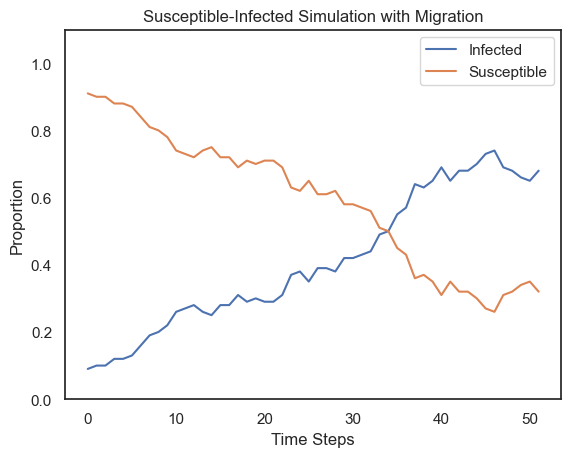

In [40]:
si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False)

x_o_raw = si_model.get_observed_data(29)
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Infected")
plt.plot(S_o, label="Susceptible")
plt.legend(loc="upper right")
plt.xlabel("Time Steps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("Susceptible-Infected Simulation with Migration")
plt.show()

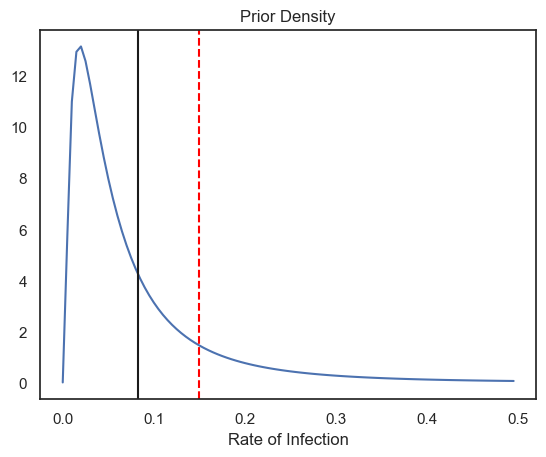

In [41]:
# visualize prior
np.random.seed(10)
x = np.arange(0, 0.5, 0.005)
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma))
ax.set_xlabel("Rate of Infection")
ax.set_title(f"Prior Density")
prior_mean = np.exp(prior_mu + prior_sigma**2/2)
plt.axvline(prior_mean, color="k")
plt.axvline(beta_true, color="red", linestyle="--")
plt.show()

In [23]:
# np.random.seed(10)
# x = np.arange(-6, 0, 0.01)
# ax = sns.lineplot(x=x, y=norm.pdf(x, prior_mu, prior_sigma))
# ax.set_xlabel("Rate of Infection")
# ax.set_title(f"Prior Density (Log Scale)")
# plt.axvline(prior_mu, color="k")
# plt.axvline(np.log(beta_true), color="red", linestyle="--")
# plt.show()

A reasonably well-calibrated prior: $P(\beta > \beta^*) = 0.15$.

### Prior Predictive Check

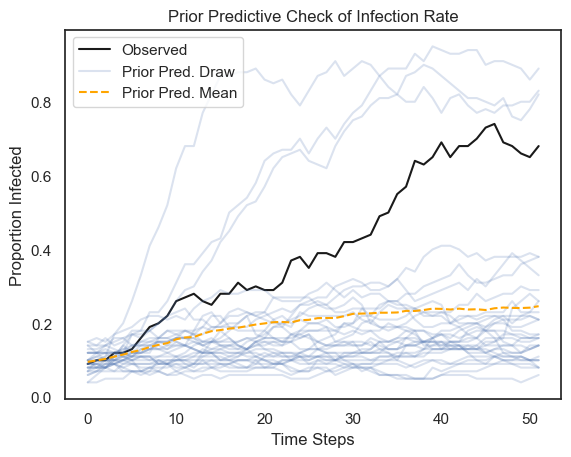

In [42]:
prior = norm(prior_mu, prior_sigma)
prior_sample = np.exp(prior.rvs(size=K, random_state=2))
prior_predictive = np.empty((K, T))

for i in range(K):
    si_model = SIModel(alpha, gamma, prior_sample[i], 
                    heterogeneous, prior_mu, prior_sigma, 
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    prior_predictive[i] =  np.array(x_rep)[0]
prp_mean = prior_predictive.mean(0)

labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(prior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(prp_mean, label="Prior Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Prior Predictive Check of Infection Rate")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

## Likelihood-based

In [45]:
true_post_mean = -1.99
true_post_sd = 0.0949
true_post_exp = 0.137

## NPE

In [43]:
npe_results = {
    "Method": ["NPE"] * 6,
    "Simulations": [125, 250, 500, 1000, 2000, 4000],
    "mean": [-1.914, -1.972, -1.95, -2.013, -1.971, -1.985],
    "sd": [.162, .156, 0.139, .151, .125, .145]
}
df_npe = pd.DataFrame(npe_results)
df_npe["Posterior Mean"] = np.exp(df_npe["mean"] + df_npe["sd"]**2/2)
df_npe[".05"] = np.exp(norm(df_npe["mean"], df_npe["sd"]).ppf(0.05))
df_npe[".95"] = np.exp(norm(df_npe["mean"], df_npe["sd"]).ppf(0.95))

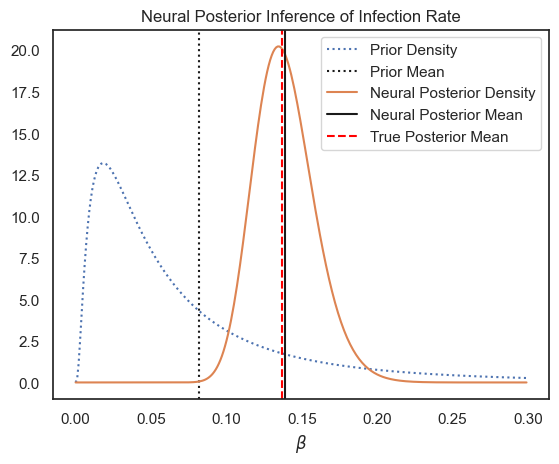

In [47]:
mu = df_npe["mean"].iloc[-1]
sigma = df_npe["sd"].iloc[-1]
np.random.seed(10)
x = np.arange(0., 0.3, 0.001)
ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
                   label="Prior Density", linestyle=":")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mean, color="k", linestyle=":", label="Prior Mean")
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Neural Posterior Density")
plt.axvline(posterior_mean, color="k", label="Neural Posterior Mean")
plt.axvline(true_post_exp, color="red", linestyle="--", label=r"True Posterior Mean")
ax.set_xlabel(r"$\beta$")
ax.set_title(f"Neural Posterior Inference of Infection Rate")
plt.legend()
plt.show()

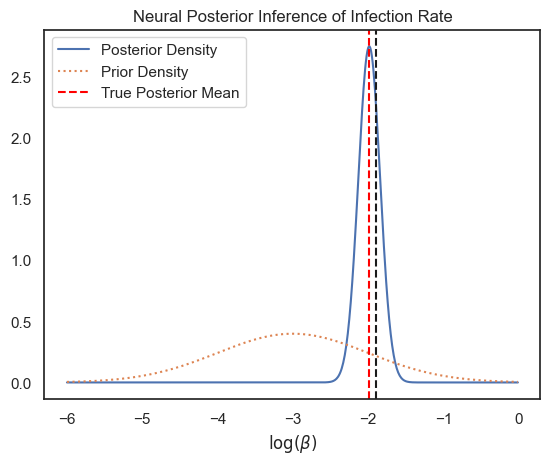

In [50]:
np.random.seed(10)
x = np.arange(-6., 0, 0.01)
ax = sns.lineplot(x=x, y=norm.pdf(x, mu, sigma), label="Posterior Density")
ax1 = sns.lineplot(x=x, y=norm.pdf(x, prior_mu, prior_sigma), 
                   label="Prior Density", linestyle=":")
ax.set_xlabel(r"$\log (\beta)$")
ax.set_title(f"Neural Posterior Inference of Infection Rate")
posterior_mean = np.exp(mu + sigma**2/2)
# plt.axvline(prior_mu, color="k", linestyle=":")
# plt.axvline(mu, color="k")
plt.axvline(true_post_mean, color="red", linestyle="--", label=r"True Posterior Mean")
plt.legend()
plt.show()

## Posterior Predictive Checks

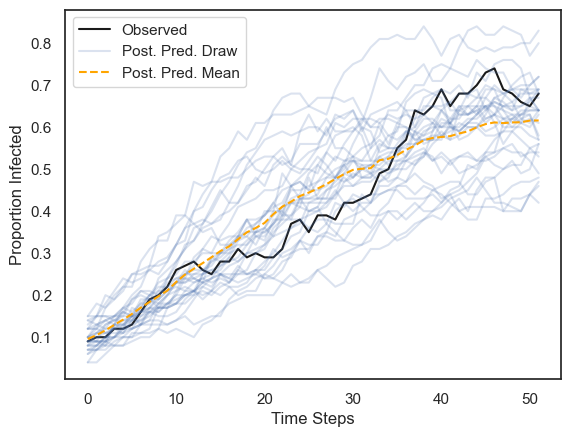

In [51]:
neural_posterior = norm(mu, sigma)
K = 30
npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
posterior_predictive = np.empty((K, T))


for i in range(K):
    si_model = SIModel(alpha, gamma, npe_sample[i], 
                   heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive[i] =  np.array(x_rep)[0]
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

## ABC

In [65]:
# testing
eps = .01
summarize = True
si_model = SIModel(alpha, gamma, beta_true, 
                n_zones, prior_mu, prior_sigma, 
               N, T, summarize=summarize)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data(29)
x_o = x_o.transpose(0, 1)
S = 100

posterior_sample, errors = abc_rejection_sampler(
    S, eps, prior_sampler, simulator, x_o, max_attempts=100000,
    summarize=summarize
    )
np.exp(posterior_sample).mean()

Time lapsed: 5.41 seconds
With tolerance 0.01, acceptance rate: 0.015810
Total number of attempts: 6,325


0.1263973

In [82]:
abc_data = {"summarize":[], "epsilon":[], "simulations":[]}
abc_samples = []

args = [(False, [5, 2, 1, 0.5, 0.4]),
        (True, [0.5, 0.2, 0.1, 0.02, 0.01])]
for summarize, es in args:
    for epsilon in es:
        si_model = SIModel(alpha, gamma, beta_true, 
                        n_zones, prior_mu, prior_sigma, 
                       N, T, summarize=summarize)
        prior_sampler = lambda: si_model.sample_logbeta(1)
        simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
        x_o = si_model.get_observed_data(29)
        x_o = x_o.transpose(0, 1)
        S = 100
        print(f"epsilon: {epsilon}")
        posterior_sample, errors = abc_rejection_sampler(
            S, epsilon, prior_sampler, simulator, x_o, max_attempts=30000,
            summarize=summarize
            )
        print("***")
        abc_data["summarize"].append(summarize)
        abc_data["epsilon"].append(epsilon)
        abc_data["simulations"].append((errors > 0).sum())
        abc_samples.append(posterior_sample[:,0])

epsilon: 5
Time lapsed: 0.11 seconds
With tolerance 5, acceptance rate: 1.000000
Total number of attempts: 100
***
epsilon: 2
Time lapsed: 0.19 seconds
With tolerance 2, acceptance rate: 0.467290
Total number of attempts: 214
***
epsilon: 1
Time lapsed: 0.54 seconds
With tolerance 1, acceptance rate: 0.158479
Total number of attempts: 631
***
epsilon: 0.5
Time lapsed: 4.38 seconds
With tolerance 0.5, acceptance rate: 0.019257
Total number of attempts: 5,193
***
epsilon: 0.4
Time lapsed: 21.03 seconds
With tolerance 0.4, acceptance rate: 0.003992
Total number of attempts: 25,053
***
epsilon: 0.5
Time lapsed: 0.08 seconds
With tolerance 0.5, acceptance rate: 1.000000
Total number of attempts: 100
***
epsilon: 0.2
Time lapsed: 0.22 seconds
With tolerance 0.2, acceptance rate: 0.386100
Total number of attempts: 259
***
epsilon: 0.1
Time lapsed: 0.57 seconds
With tolerance 0.1, acceptance rate: 0.147710
Total number of attempts: 677
***
epsilon: 0.02
Time lapsed: 2.73 seconds
With tolerance

In [149]:
df_abc = pd.DataFrame(abc_data)

abc_posterior = np.array(abc_samples)
df_abc["Posterior Mean"] = np.exp(abc_posterior).mean(1)

df_abc[".05"] = np.quantile(np.exp(abc_posterior), 0.05, 1)
df_abc[".95"] = np.quantile(np.exp(abc_posterior), 0.95, 1)
df_abc["sd"] = abc_posterior.std(1)
df_abc["mean"] = abc_posterior.mean(1)
df_abc["Method"] = df_abc["summarize"].apply(lambda x: "ABC-S" if x else "ABC")
df_abc = df_abc.rename(columns={"simulations":"Simulations"})

In [150]:
df_results = pd.concat([df_npe, 
           df_abc[["Method", "Simulations", "Posterior Mean", ".05", ".95", "mean", "sd"]]])

In [120]:
npe = df_results[df_results["Method"] == "NPE"]
abc = df_results[df_results["Method"] == "ABC"]
abcs = df_results[df_results["Method"] == "ABC-S"]

In [121]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

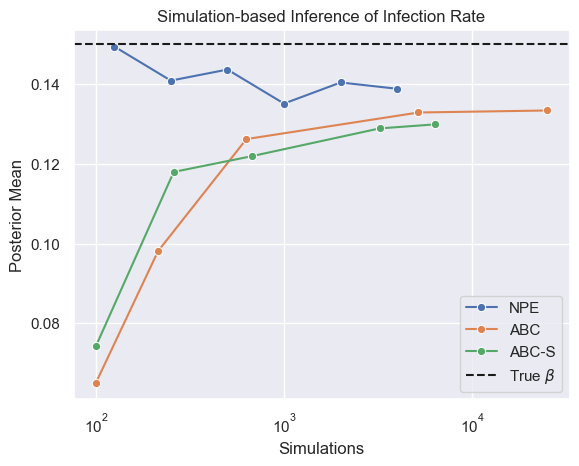

In [129]:
ax = sns.lineplot(df_results, x="Simulations", y="Posterior Mean", marker="o", hue="Method")
ax.axhline(y = 0.15, color="k", label=r"True $\beta$", linestyle="--")
plt.legend()
plt.xscale("log")
plt.xlabel("Simulations")
plt.ylabel(r"Posterior Mean")
plt.title("Simulation-based Inference of Infection Rate")
plt.show()

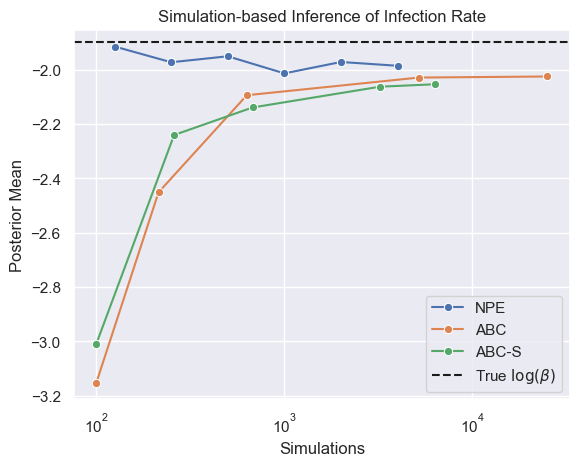

In [158]:
ax = sns.lineplot(df_results, x="Simulations", y="mean", marker="o", hue="Method")
ax.axhline(y = np.log(0.15), color="k", label=r"True $\log(\beta)$", linestyle="--")
plt.legend()
plt.xscale("log")
plt.xlabel("Simulations")
plt.ylabel(r"Posterior Mean")
plt.title("Simulation-based Inference of Infection Rate")
plt.show()

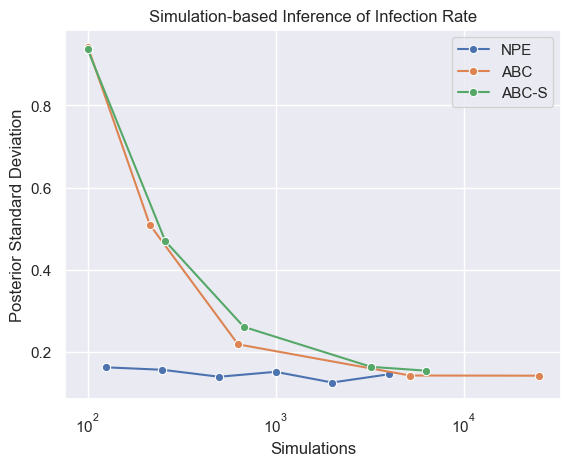

In [130]:
ax = sns.lineplot(df_results, x="Simulations", y="sd", marker="o", hue="Method")
plt.legend()
plt.xscale("log")
plt.xlabel("Simulations")
plt.ylabel(r"Posterior Standard Deviation")
plt.title("Simulation-based Inference of Infection Rate")
plt.show()

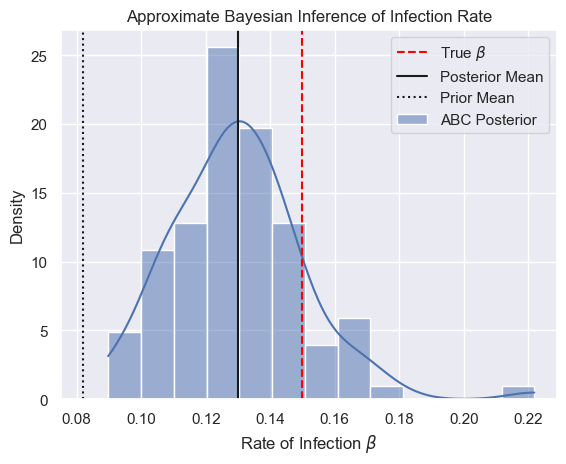

In [159]:
ax = sns.histplot(np.exp(abc_posterior[-1]), stat="density", kde=True, label="ABC Posterior")
ax.set_xlabel(r"Rate of Infection $\beta$")
ax.set_title(r"Approximate Bayesian Inference of Infection Rate")
plt.axvline(beta_true, color="red", linestyle="--", label=r"True $\beta$")
plt.axvline(np.exp(abc_posterior[-1]).mean(), color="k", label="Posterior Mean")
plt.axvline(prior_mean, color="k", linestyle=":", label="Prior Mean")
#x.get_legend().remove()
plt.legend()
plt.show()

### ABC PPC

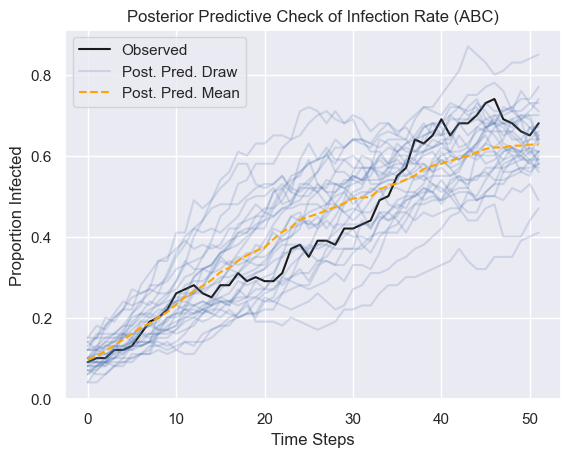

In [93]:
posterior_predictive_abc = np.empty((K, T))
for i in range(30):
    beta = np.exp(abc_posterior[-1][i])
    si_model = SIModel(alpha, gamma, beta, 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive_abc[i] =  np.array(x_rep)[0]
pp_mean_abc = posterior_predictive_abc.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive_abc.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean_abc, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Posterior Predictive Check of Infection Rate (ABC)")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

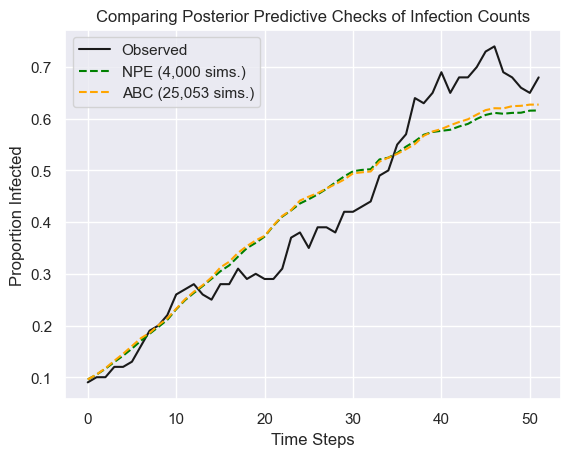

In [96]:
plt.plot(I_o, label="Observed", color="k")
plt.plot(pp_mean, label="NPE (4,000 sims.)", linestyle="--",
         color="green")
plt.plot(pp_mean_abc, label="ABC (25,053 sims.)", linestyle="--",
         color="orange")
plt.legend()
plt.title("Comparing Posterior Predictive Checks of Infection Counts")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

NPE posterior predictive mean is virtually identifical!

# Interventions

In [150]:
K = 30
neural_posterior = norm(mu, sigma)
npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
pis = [1, 0.8, .6, .4, .2]
intervention = np.empty((K, len(pis), T))
for j, pi in enumerate(pis):
    for i in range(30):
        beta = npe_sample[i]
        si_model = SIModel(alpha, gamma, beta, 
                       heterogeneous, prior_mu, prior_sigma,
                       N, T, summarize=False, pi=pi)
        x_rep = si_model.get_observed_data(i)
        intervention[i, j] =  np.array(x_rep)[0]

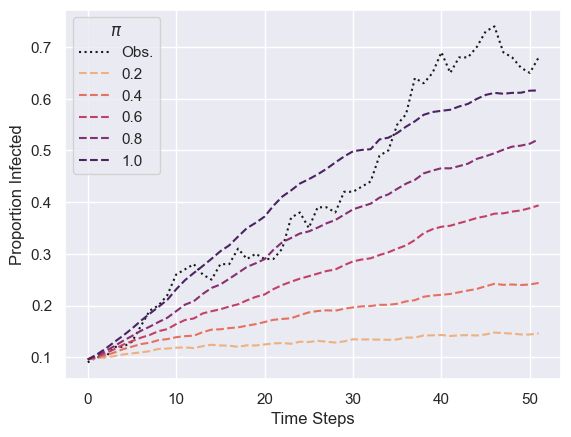

In [280]:
int_data = intervention.mean(0)
df_int = pd.DataFrame(int_data.T, columns=pis)
plt.plot(I_o, label="Obs.", color="k", linestyle=":")
df_int = df_int.melt(var_name=r"$\pi$", ignore_index=False)
sns.lineplot(df_int.reset_index(), x = "index", y="value", hue=r"$\pi$",
             palette="flare", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.show()

# Prior Strength 

In [10]:
prior_strength_npe = pd.read_csv("prior_strength.csv", index_col=0).reset_index(drop=True)

In [11]:
prior_strength_npe = prior_strength_npe[["prior_sigma", "mu", "sigma", "posterior_mean", "n_sample"]]
prior_strength_npe["method"] = "NPE"

In [27]:
# testing
prior_strength_abc = {"prior_sigma": [], "mu": [],
                      "sigma": [], "posterior_mean": [],
                      "n_sample": []}
n_accepts = 50
for prior_sigma in 4,2,1,0.5,0.25:
    for S in [500]:# , 2000:
        prior_mu = -1.9
        summarize = False
        si_model = SIModel(alpha, gamma, beta_true, 
                        heterogeneous, prior_mu, prior_sigma, 
                    N, T, summarize=summarize)
        prior_sampler = lambda: si_model.sample_logbeta(1)
        simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
        x_o = si_model.get_observed_data(29)
        posterior_sample, errors = abc_rejection_sampler2(S, prior_sampler, simulator, x_o, summarize)
        accepted = posterior_sample[errors.argsort()[:n_accepts]]
        prior_strength_abc["prior_sigma"].append(prior_sigma)
        prior_strength_abc["mu"].append(accepted.mean())
        prior_strength_abc["sigma"].append(accepted.std())
        prior_strength_abc["posterior_mean"].append(np.exp(accepted).mean())
        prior_strength_abc["n_sample"].append(S)

In [28]:
df_prior_strength = pd.DataFrame(prior_strength_abc)
df_prior_strength["method"] = "ABC"

In [29]:
df_prior_strength = pd.concat([df_prior_strength, prior_strength_npe])
df_prior_strength["log_precision"] = np.log2(df_prior_strength["prior_sigma"] ** -2)

In [30]:
df_prior_strength = df_prior_strength.sort_values(["method", "log_precision"])

df_ps_npe = df_prior_strength[df_prior_strength["method"] == "NPE"]
df_ps_abc = df_prior_strength[(df_prior_strength["method"] == "ABC") & (df_prior_strength["n_sample"] == 500)]
# df_ps_abc2 = df_prior_strength[(df_prior_strength["method"] == "ABC") & (df_prior_strength["n_sample"] == 2000)]

npe_error = df_ps_npe["sigma"]
abc_error = df_ps_abc["sigma"]
# abc_error2  = df_ps_abc2["sigma"]
npe_lower, npe_upper = df_ps_npe["mu"] - npe_error, df_ps_npe["mu"] + npe_error

abc_lower, abc_upper = df_ps_abc["mu"] - abc_error, df_ps_abc["mu"] + abc_error

# abc_lower2, abc_upper2 = df_ps_abc2["mu"] - abc_error2, df_ps_abc2["mu"] + abc_error2



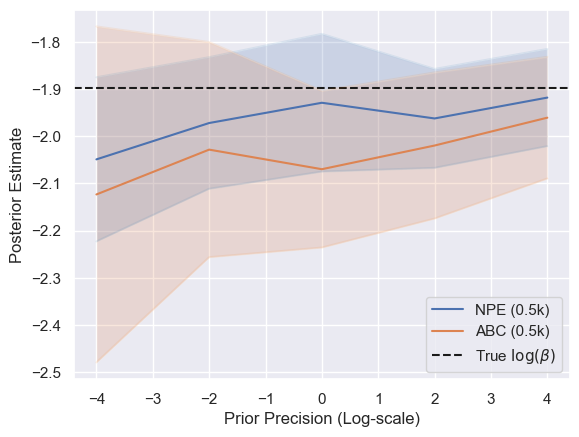

In [31]:
plt.plot(df_ps_npe["log_precision"], df_ps_npe["mu"], label="NPE (0.5k)")
plt.plot(df_ps_abc["log_precision"], df_ps_abc["mu"], label="ABC (0.5k)")
# plt.plot(df_ps_abc2["log_precision"], df_ps_abc2["mu"], label="ABC (2k)")
plt.axhline(np.log(.15), linestyle="--", color="k", label=r"True $\log (\beta)$")

plt.plot(df_ps_npe["log_precision"],
         npe_lower, color='tab:blue', alpha=0.1)
plt.plot(df_ps_npe["log_precision"],
         npe_upper, color='tab:blue', alpha=0.1)
plt.fill_between(df_ps_npe["log_precision"], npe_lower, npe_upper, alpha=0.2)

plt.plot(df_ps_npe["log_precision"],
         abc_lower, color='tab:orange', alpha=0.1)
plt.plot(df_ps_npe["log_precision"],
         abc_upper, color='tab:orange', alpha=0.1)
plt.fill_between(df_ps_npe["log_precision"], abc_lower, abc_upper, alpha=0.2)

# plt.plot(df_ps_npe["log_precision"],
#          abc_lower2, color='tab:green', alpha=0.1)
# plt.plot(df_ps_npe["log_precision"],
#          abc_upper2, color='tab:green', alpha=0.1)
# plt.fill_between(df_ps_npe["log_precision"], abc_lower2, abc_upper2, alpha=0.2)

plt.xlabel("Prior Precision (Log-scale)")
plt.ylabel("Posterior Estimate")
plt.legend()
plt.show()

In [270]:
df_prior_mu = pd.read_csv("prior_strength2.csv")[["mu", "sigma", "prior_mu", "n_sample"]]
df_prior_mu["method"] = "NPE"

In [274]:
# part 2
df_temp = []
for prior_mu in [-4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5]:
    for S in 500, 2000:
        prior_sigma = 1
        summarize = False
        si_model = SIModel(alpha, gamma, beta_true, 
                        heterogeneous, prior_mu, prior_sigma, 
                    N, T, summarize=summarize)
        prior_sampler = lambda: si_model.sample_logbeta(1)
        simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
        x_o = si_model.get_observed_data(29)
        posterior_sample, errors = abc_rejection_sampler2(S, prior_sampler, simulator, x_o, summarize)
        accepted = posterior_sample[errors.argsort()[:100]]
        df_temp.append([accepted.mean(), accepted.std(), prior_mu, S, "ABC"])
    # prior_strength_abc["prior_sigma"].append(prior_sigma)
    # prior_strength_abc["mu"].append(accepted.mean())
    # prior_strength_abc["sigma"].append(accepted.std())
    # prior_strength_abc["posterior_mean"].append(np.exp(accepted).mean())
    # pd.DataFrame(columns=["mu", "sigma", "prior_mu", "n_sample", "method"])

df_temp = pd.DataFrame(df_temp, columns=["mu", "sigma", "prior_mu", "n_sample", "method"])

In [275]:
df_prior_mu = pd.concat([df_prior_mu, df_temp])

In [276]:
df_prior_mu = df_prior_mu.sort_values(["method", "prior_mu"])

df_pm_npe = df_prior_mu[df_prior_mu["method"] == "NPE"]
df_pm_abc1 = df_prior_mu[(df_prior_mu["method"] == "ABC") & (df_prior_mu["n_sample"] == 500)]

df_pm_abc2 = df_prior_mu[(df_prior_mu["method"] == "ABC") & (df_prior_mu["n_sample"] == 2000)]

npe_error = df_pm_npe["sigma"]
abc_error1 = df_pm_abc1["sigma"]
abc_error2 = df_pm_abc2["sigma"]

npe_lower, npe_upper = df_pm_npe["mu"] - npe_error, df_pm_npe["mu"] + npe_error

abc_lower1, abc_upper1 = df_pm_abc1["mu"] - abc_error1, df_pm_abc1["mu"] + abc_error1

abc_lower2, abc_upper2 = df_pm_abc2["mu"] - abc_error2, df_pm_abc2["mu"] + abc_error2

x = df_pm_npe["prior_mu"] - np.log(.15)

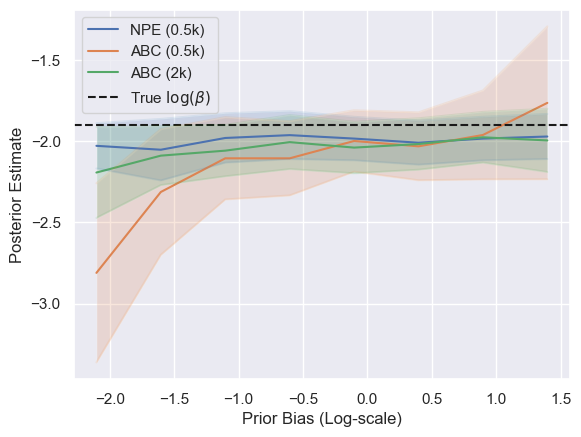

In [277]:
plt.plot(x, df_pm_npe["mu"], label="NPE (0.5k)")
plt.plot(x, df_pm_abc1["mu"], label="ABC (0.5k)")
plt.plot(x, df_pm_abc2["mu"], label="ABC (2k)")

plt.axhline(np.log(.15), linestyle="--", color="k", label=r"True $\log (\beta)$")

plt.plot(x,
         npe_lower, color='tab:blue', alpha=0.1)
plt.plot(x,
         npe_upper, color='tab:blue', alpha=0.1)
plt.fill_between(x, npe_lower, npe_upper, alpha=0.2)

plt.plot(x,
         abc_lower1, color='tab:orange', alpha=0.1)
plt.plot(x,
         abc_upper1, color='tab:orange', alpha=0.1)
plt.fill_between(x, abc_lower1, abc_upper1, alpha=0.2)

plt.plot(x,
         abc_lower2, color='tab:green', alpha=0.1)
plt.plot(x,
         abc_upper2, color='tab:green', alpha=0.1)
plt.fill_between(x, abc_lower2, abc_upper2, alpha=0.2)
plt.xlabel("Prior Bias (Log-scale)")
plt.ylabel("Posterior Estimate")
plt.legend()
plt.show()

In [ ]:
df_prior_strength = df_prior_strength.sort_values(["method", "log_precision"])

df_ps_npe = df_prior_strength[df_prior_strength["method"] == "NPE"]
df_ps_abc = df_prior_strength[df_prior_strength["method"] == "ABC"]

npe_error = df_ps_npe["sigma"]
abc_error = df_ps_abc["sigma"]
npe_lower, npe_upper = df_ps_npe["mu"] - npe_error, df_ps_npe["mu"] + npe_error

abc_lower, abc_upper = df_ps_abc["mu"] - abc_error, df_ps_abc["mu"] + abc_error

What can we say about the above?

Prior Strength and 

In [29]:
df_prior_strength

,prior_sigma,mu,sigma,posterior_mean
0,4.00,-2.139423,0.518027,0.133246
1,2.00,-2.043803,0.381779,0.138971
2,1.00,-2.015217,0.197312,0.135917
3,0.50,-2.033364,0.163299,0.132662
4,0.25,-1.976526,0.138879,0.139876


In [12]:
for prior_sigma in [4,2,1,0.5,0.25]:
    prior_mu = -1.9 # -2
    eps = .5
    summarize = False
    si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma, 
                   N, T, summarize=summarize)
    prior_sampler = lambda: si_model.sample_logbeta(1)
    simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
    x_o = si_model.get_observed_data(29)
    S = 100
    posterior_sample, errors = abc_rejection_sampler(
                S, eps, prior_sampler, simulator, x_o, max_attempts=30000,
                summarize=summarize
                )
    print(prior_sigma)
    print(posterior_sample.mean(), posterior_sample.std())
    print(np.exp(posterior_sample.mean()))

Attempts: 5,000
Attempts: 10,000
Time lapsed: 15.60 seconds
With tolerance 0.5, acceptance rate: 0.006989
Total number of attempts: 14,308
4
-2.0251005 0.13564578
0.13198058
Attempts: 5,000
Time lapsed: 8.96 seconds
With tolerance 0.5, acceptance rate: 0.012235
Total number of attempts: 8,173
2
-1.9685022 0.15053444
0.1396659
Time lapsed: 4.63 seconds
With tolerance 0.5, acceptance rate: 0.023702
Total number of attempts: 4,219
1
-2.018999 0.14670363
0.1327883
Time lapsed: 2.58 seconds
With tolerance 0.5, acceptance rate: 0.042535
Total number of attempts: 2,351
0.5
-1.9927026 0.1345419
0.13632649
Time lapsed: 1.39 seconds
With tolerance 0.5, acceptance rate: 0.078864
Total number of attempts: 1,268
0.25
-1.9832748 0.12690867
0.13761783
